# Загрузка данных

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import CubicSpline


In [43]:
def load_data(file_path: str) -> np.ndarray:
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(float(line.strip()))
    return data

data = load_data('data.txt')

# Построение таблиц

## **Таблица 1:** Результаты прямых измерений

In [44]:
def create_data_table(data: np.ndarray) -> pd.DataFrame:
    t_mean = np.mean(data)
    t_deviation = data - t_mean
    t_deviation_squared = t_deviation ** 2

    df = pd.DataFrame({
        't_i, c': data,
        't_i - t_mean': t_deviation,
        '(t_i - t_mean)^2': t_deviation_squared,
    })

    return df.round(3)

create_data_table(data)

,"t_i, c",t_i - t_mean,(t_i - t_mean)^2
0,6.945,-0.046,0.002
1,6.949,-0.041,0.002
2,6.851,-0.139,0.019
3,7.114,0.124,0.015
4,7.040,0.049,0.002
...,...,...,...
95,6.821,-0.169,0.029
96,6.991,0.001,0.000
97,7.211,0.221,0.049
98,6.895,-0.096,0.009


## **Таблица 2:** Данные для построения гистограммы

In [45]:
def create_hist_data_table(data: np.ndarray) -> pd.DataFrame:
    bins, bin_edges, patches = plt.hist(data, bins=10, density=False, edgecolor='black')
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    mean, std = np.mean(data), np.std(data)
    p_values = [1 / (std * np.sqrt(2 * np.pi)) * np.exp(-(t0 - mean) ** 2 / (2 * std ** 2)) for t0 in bin_centers]
    df = pd.DataFrame({
        'Начало интервала': bin_edges[:-1],
        'Конец интервала': bin_edges[1:],
        '∆N': bins,
        '∆N / (Т * ∆t)': bins / np.sum(bins) / np.diff(bin_edges),
        't': bin_centers,
        'p': p_values
    })
    plt.close()

    return df.round(3)

create_hist_data_table(data)

,Начало интервала,Конец интервала,∆N,∆N / (Т * ∆t),t,p
0,6.692,6.748,2.0,0.357,6.720,0.232
1,6.748,6.805,4.0,0.713,6.777,0.633
2,6.805,6.861,10.0,1.783,6.833,1.368
3,6.861,6.917,11.0,1.961,6.889,2.343
4,6.917,6.973,15.0,2.674,6.945,3.178
5,6.973,7.029,19.0,3.387,7.001,3.417
6,7.029,7.085,17.0,3.031,7.057,2.911
7,7.085,7.141,14.0,2.496,7.113,1.965
8,7.141,7.197,6.0,1.070,7.169,1.051
9,7.197,7.253,2.0,0.357,7.225,0.445


## **Таблица 3:** стандартные доверительные интервалы

In [46]:
def create_probabilities_data_table(data: np.ndarray) -> pd.DataFrame:
    mean, std = np.mean(data), np.std(data)
    lower_1std = mean - std
    upper_1std = mean + std
    lower_2std = mean - 2 * std
    upper_2std = mean + 2 * std
    lower_3std = mean - 3 * std
    upper_3std = mean + 3 * std
    dN_1std = np.sum((data >= lower_1std) & (data <= upper_1std))
    dN_2std = np.sum((data >= lower_2std) & (data <= upper_2std))
    dN_3std = np.sum((data >= lower_3std) & (data <= upper_3std))
    p_std = dN_1std / len(data)
    p_2std = dN_2std / len(data)
    p_3std = dN_3std / len(data)
    df = pd.DataFrame({
        "interval_begin": [lower_1std, lower_2std, lower_3std],
        "interval_end": [upper_1std, upper_2std, upper_3std],
        "△N": [dN_1std, dN_2std, dN_3std],
        "△N / N": [p_std, p_2std, p_3std],
        "P": [0.683, 0.954, 0.997]
    }, index=["⟨t⟩N ± std", "⟨t⟩N ± 2std", "⟨t⟩N ± 3std"])
    return df.round(3)


create_probabilities_data_table(data)

,interval_begin,interval_end,△N,△N / N,P
⟨t⟩N ± std,6.874,7.107,63,0.63,0.683
⟨t⟩N ± 2std,6.758,7.223,95,0.95,0.954
⟨t⟩N ± 3std,6.641,7.339,100,1.00,0.997


# Потсроение гистограммы и функции плотности распределения

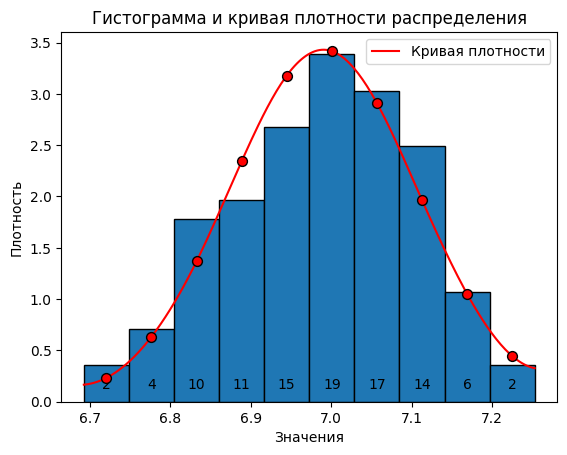

In [52]:
def plot_hist(data: np.ndarray) -> None:
    mean, std = np.mean(data), np.std(data)

    n, bins, patches = plt.hist(data, bins=10, edgecolor='black', density=True)
    counts, _ = np.histogram(data, bins=bins)

    for i in range(len(patches)):
        bin_center = (bins[i] + bins[i + 1]) / 2
        plt.text(bin_center, 0.1, str(counts[i]), ha='center', va='bottom')

    bin_centers = (bins[:-1] + bins[1:]) / 2
    p_values = [1 / (std * np.sqrt(2 * np.pi)) * np.exp(-(t0 - mean) ** 2 / (2 * std ** 2)) for t0 in bin_centers]

    spline = CubicSpline(bin_centers, p_values)
    x_smooth = np.linspace(bins[0], bins[-1], 200)
    y_smooth = spline(x_smooth)

    plt.plot(x_smooth, y_smooth, color='red', label='Кривая плотности')
    plt.scatter(bin_centers, p_values, color='red', s=50, edgecolor='black', zorder=5)
    plt.title("Гистограмма и кривая плотности распределения")
    plt.xlabel("Значения")
    plt.ylabel("Плотность")
    plt.legend()
    plt.savefig("hist.png")
    plt.show()
    plt.close()

plot_hist(data)

# Подсчёт нужных велечин

Выборочное среднее значение: $\langle t \rangle_N = \frac{1}{N} \sum_{i=1}^{N} t_i$

In [48]:
print(f"{np.mean(data):.3f}")

6.990


Выборочное среднее отклонение: $\sigma_N = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (t_i - \langle t \rangle_N)^2}
$

In [49]:
print(f"{np.std(data):.3f}")

0.116


Максимальное значение плотности распределения: $p_{max} = \frac{\displaystyle 1}{ \displaystyle \sigma \sqrt{2 \pi}}$

In [50]:
print(f"{(1 / (np.std(data) * np.sqrt(2 * np.pi))):.3f}")

3.431


Cреднеквадратичное отклонение среднего значения: $\sigma_{\langle t \rangle} = \frac{\displaystyle \sigma}{\displaystyle \sqrt{N - 1}}$

In [51]:
print(f"{np.std(data) / np.sqrt(len(data) - 1):.3f}")

0.012


$\frac{1}{\sigma \sqrt{2 \pi}} \exp\left(-\frac{(t_0 - \mu)^2}{2 \sigma^2}\right)$

Коэфицент Стюдента $t_{a, N}$ для доверительного интервала 0.95, и выборки размером 100

In [54]:
import scipy.stats as stats

confidence = 0.95
n = len(data)
df = n - 1
t_value = stats.t.ppf((1 + confidence) / 2, df)

print(f"Коэффициент Стьюдента для доверительного уровня {confidence} и {n} элементов: {t_value:.3f}")
print(f"{(np.mean(data) - t_value):.3f}, {(np.mean(data) + t_value):.3f}")

Коэффициент Стьюдента для доверительного уровня 0.95 и 100 элементов: 1.984
5.006, 8.974
